

# Build a Traffic Sign Recognition Classifier

This notebook contains python code implementation of the traffic sign classifier using Convolutional Neural Network approach. 


---
## Step 0: Load The Data

The below cell contains code to load the variables from the pickled files.

In [1]:

import pickle
import numpy as np

training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_original, y_train = train['features'], train['labels']
X_train=np.copy( X_train_original)
X_valid_original, y_valid = valid['features'], valid['labels']
X_valid=np.copy(X_valid_original)
X_test_original, y_test = test['features'], test['labels']
X_test=np.copy(X_test_original)

print('Loaded the data.')

Loaded the data.


---

## Step 1: Dataset Summary & Exploration

The data obtained from the pickled files is already clean. All the image files are brought to the same size(32 X 32 pixels). This data contained 43 types of traffic signs, under different ambient lighting, and orientation conditions. 

### Basic Summary of the Data Set 

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results


# TODO: Number of training examples
n_train =  X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

A sample image shown below is at index 3533 with a label 18:


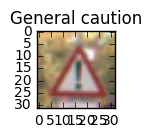

Different images from the list are below
0


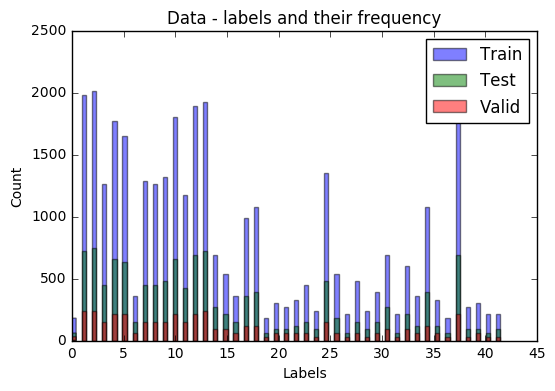

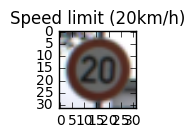

1


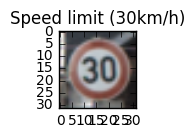

2


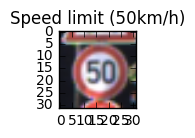

3


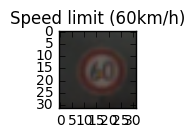

4


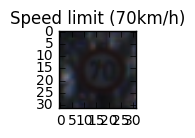

5


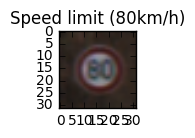

6


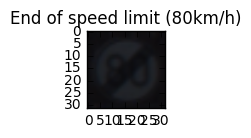

7


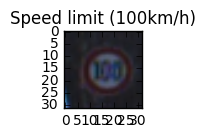

8


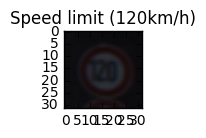

9


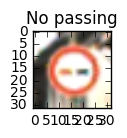

10


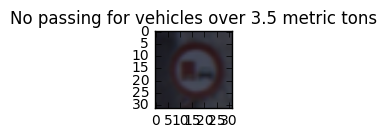

11


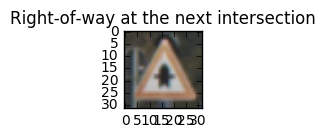

12


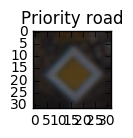

13


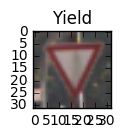

14


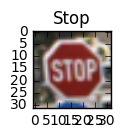

15


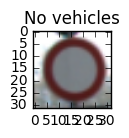

16


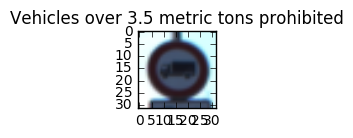

17


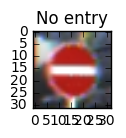

18


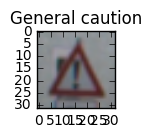

19


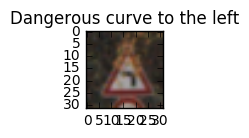

20


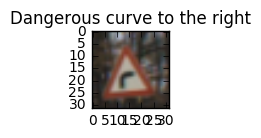

21


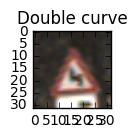

22


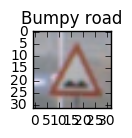

23


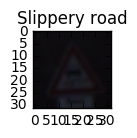

24


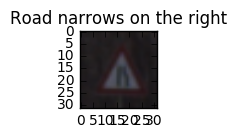

25


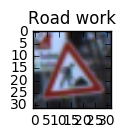

26


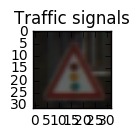

27


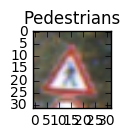

28


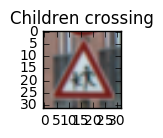

29


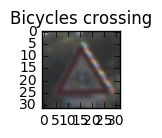

30


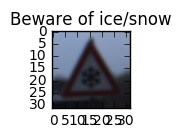

31


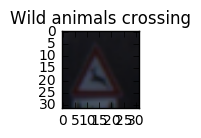

32


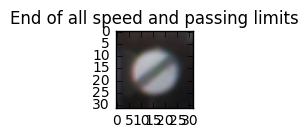

33


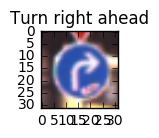

34


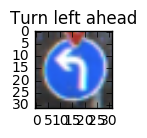

35


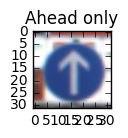

36


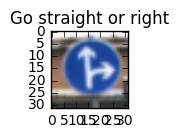

37


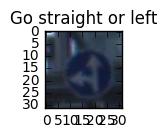

38


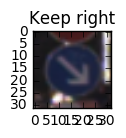

39


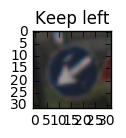

40


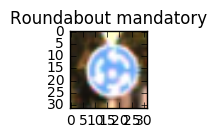

41


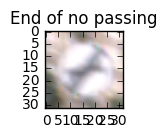

42


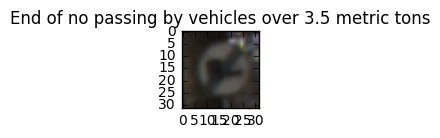

In [3]:

import matplotlib.pyplot as plt
import random
import csv 
from sklearn.utils import shuffle

with open('signnames.csv','r')  as file:
    reader1=csv.reader(file)
    namesList=np.array(list(reader1))
mynames=namesList[1:,1]
    
%matplotlib inline

def plotmyimage(img,title=''):
    #This function is used during the debug phase. 
    #This just plots the image 
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='gray') 
    plt.title(title)
    plt.show()

X_train,y_train = shuffle(X_train,y_train)
randindex=random.randint(0,len(X_train))
print('A sample image shown below is at index {} with a label {}:'.format(randindex,y_train[randindex]))
randimage=X_train[randindex]
plotmyimage(randimage,mynames[y_train[randindex]])
plt.hist(y_train,n_classes,width=0.4,label='Train',alpha=0.5)
plt.hist(y_test,n_classes,width=0.4,label='Test',alpha=0.5)
plt.hist(y_valid,n_classes,width=0.4,label='Valid',alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Data - labels and their frequency')

print('Different images from the list are below')
for i in range(n_classes):
    print(i)
    s=np.where(y_train==i)
    plotmyimage(X_train[s[0][0]],mynames[i])


----

## Step 2: Model Architecture


There was a suggestion to look at [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) for inspirations, but I am not yet familiar with implementing parallel paths in same layer. I implemented my model as straightforward architecture, with just an additional layer compared to LeNet-5

### Pre-process the Data Set


In [4]:


import cv2

def ScaleDownImagesRGB(inArray):
    imageArray=np.copy(inArray)
    for i in range(len(imageArray)):
        yuv=cv2.cvtColor(imageArray[i],cv2.COLOR_BGR2YUV)
        yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
        imageArray[i]=cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
        imageArray[i]=imageArray[i].astype(np.float32)
    imageArray=(imageArray-128)/128
    return imageArray,3



def ScaleDownImagesGray(ColorArray):
    GrayArray=np.zeros((ColorArray.shape[0],ColorArray.shape[1],ColorArray.shape[2],1))
    for i in range(len(ColorArray)):
        GrayArray[i,:,:,0]=cv2.equalizeHist(cv2.cvtColor(ColorArray[i].astype(np.uint8),cv2.COLOR_RGB2GRAY))
        GrayArray[i]=(GrayArray[i]-128)/128
    return GrayArray,1


  
    
#X_train,Image_Channels=ScaleDownImagesRGB(X_train)
#X_valid,Image_Channels=ScaleDownImagesRGB(X_valid)
#X_test,Image_Channels=ScaleDownImagesRGB(X_test)
#X_train=(X_train-128)/128
#X_valid=(X_valid-128)/128
#X_test=(X_test-128)/128


#X_test=(X_test-X_test.mean(axis=3,keepdims=True))/X_test.std(axis=3,keepdims=True)

X_train,Image_Channels=ScaleDownImagesGray(X_train)
X_valid,Image_Channels=ScaleDownImagesGray(X_valid)
X_test,Image_Channels=ScaleDownImagesGray(X_test)
  

print('Processed the data')

Processed the data


### Model Architecture

In [5]:
### Defined the architecture here.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #  Layer 1: Convolutional. Input = 32x32xLayers. Output = 28x28x6.
    weight1=tf.Variable(tf.truncated_normal(shape=(5,5,Image_Channels,6), mean = mu, stddev = sigma))
    bias1=tf.Variable(tf.zeros(6))
    conv_layer=tf.nn.conv2d(x,weight1,strides=[1,1,1,1],padding='VALID')
    conv_layer=tf.nn.bias_add(conv_layer, bias1)
    
    #  Activation.
    conv_layer=tf.nn.relu(conv_layer)
    
    #  Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_layer=tf.nn.max_pool(conv_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    #  Layer 2: Convolutional. Output = 10x10x16.
    weight2=tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    bias2=tf.Variable(tf.zeros(16))
    conv_layer2=tf.nn.conv2d(conv_layer,weight2,strides=[1,1,1,1],padding='VALID')
    conv_layer2=tf.nn.bias_add(conv_layer2, bias2)
    
    #  Activation.
    conv_layer2=tf.nn.relu(conv_layer2)
    
    #  Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    #  Flatten. Input = 5x5x16. Output = 400.
    fc0=flatten(conv_layer2)
    
    #  Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(5*5*16, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.nn.bias_add(tf.matmul(fc0, fc1_W) , fc1_b)
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1=tf.nn.dropout(fc1,0.9)
    
    #  Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.nn.bias_add(tf.matmul(fc1, fc2_W) , fc2_b)
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)
    
    fc2 = tf.nn.dropout(fc2, 0.65)
    
    #  Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.nn.bias_add(tf.matmul(fc2, fc3_W) , fc3_b)
    
    return logits

def MyNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #  Layer 1: Convolutional. Input = 32x32xLayers. Output = 28x28x10.
    weight1=tf.Variable(tf.truncated_normal(shape=(5,5,Image_Channels,10), mean = mu, stddev = sigma))
    bias1=tf.Variable(tf.zeros(10))
    conv_layer=tf.nn.conv2d(x,weight1,strides=[1,1,1,1],padding='VALID')
    conv_layer=tf.nn.bias_add(conv_layer, bias1)
    # TODO: Activation.
    conv_layer=tf.nn.relu(conv_layer)
    # TODO: Pooling. Input = 28x28x10. Output = 14x14x10.
    conv_layer=tf.nn.max_pool(conv_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    #  Layer 2: Convolutional. Output = 10x10x20
    weight2=tf.Variable(tf.truncated_normal(shape=(5,5,10,20), mean = mu, stddev = sigma))
    bias2=tf.Variable(tf.zeros(20))
    conv_layer2=tf.nn.conv2d(conv_layer,weight2,strides=[1,1,1,1],padding='VALID')
    conv_layer2=tf.nn.bias_add(conv_layer2, bias2)
    # TODO: Activation.
    conv_layer2=tf.nn.relu(conv_layer2)
    # TODO: Pooling. Input = 10x10x20. Output = 5x5x20.
    conv_layer2=tf.nn.max_pool(conv_layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

    #  Flatten. Input = 5x5x20. Output = 500.
    fc0=flatten(conv_layer2)
    
    # Layer 3: Fully Connected. Input = 500. Output = 700.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(500, 700), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(700))
    fc1   = tf.nn.bias_add(tf.matmul(fc0, fc1_W) , fc1_b)
    # TODO: Activation.
    fc1    = tf.nn.relu(fc1)
    #fc1=tf.nn.dropout(fc1,Keep)
    
    # Layer 4: Fully Connected. Input = 700. Output = 200.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(700, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.nn.bias_add(tf.matmul(fc1, fc2_W) , fc2_b)
    # TODO: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, Keep)
    
    #  Layer 5: Fully Connected. Input = 200. Output = 80.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 80), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(80))
    fc3 = tf.nn.bias_add(tf.matmul(fc2, fc3_W) , fc3_b)
    # TODO: Activation.
    fc3    = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, Keep)
    
    # TODO: Layer 6: Fully Connected. Input = 80. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(80, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.nn.bias_add(tf.matmul(fc3, fc4_W) , fc4_b)

    
    return logits

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, Keep:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


x = tf.placeholder(tf.float32,shape=[None,32,32,Image_Channels])
y = tf.placeholder(tf.int32, (None))
Keep=tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)




myrate=tf.placeholder(tf.float32)

logits = MyNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = myrate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


saver = tf.train.Saver()

print('Defined and created the model graph.')

Defined and created the model graph.


### Train, Validate and Test the Model

The validation set is be used to assess how well the model is performing. 

In [6]:



EPOCHS = 40
BATCH_SIZE=400
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,Keep:0.85,myrate:(0.001)})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './mynet_RGB')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.772

EPOCH 2 ...
Validation Accuracy = 0.877

EPOCH 3 ...
Validation Accuracy = 0.907

EPOCH 4 ...
Validation Accuracy = 0.925

EPOCH 5 ...
Validation Accuracy = 0.928

EPOCH 6 ...
Validation Accuracy = 0.933

EPOCH 7 ...
Validation Accuracy = 0.936

EPOCH 8 ...
Validation Accuracy = 0.939

EPOCH 9 ...
Validation Accuracy = 0.946

EPOCH 10 ...
Validation Accuracy = 0.939

EPOCH 11 ...
Validation Accuracy = 0.943

EPOCH 12 ...
Validation Accuracy = 0.942

EPOCH 13 ...
Validation Accuracy = 0.942

EPOCH 14 ...
Validation Accuracy = 0.944

EPOCH 15 ...
Validation Accuracy = 0.947

EPOCH 16 ...
Validation Accuracy = 0.944

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.941

EPOCH 19 ...
Validation Accuracy = 0.939

EPOCH 20 ...
Validation Accuracy = 0.943

EPOCH 21 ...
Validation Accuracy = 0.949

EPOCH 22 ...
Validation Accuracy = 0.948

EPOCH 23 ...
Validation Accuracy = 0.942

EPOCH 24 ...
Validation Accura

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Test Accuracy = {:.3f}".format(train_accuracy))
print('Testing the model with pickled test data.')
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 1.000
Testing the model with pickled test data.
Test Accuracy = 0.938


---

## Step 3: Test the Model on New Images

I googled german traffic signs for images for obtaining the images to test my model. To obtain the 32X32 images, I zoomed out the pages and took screenshots to match the size.


### Load and Output the Images

11 right of way.png


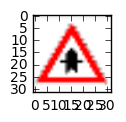

12 priority road.png


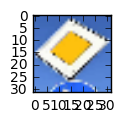

13 yield.png


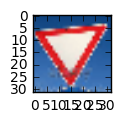

17 no entry.png


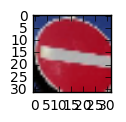

26 signal lights.png


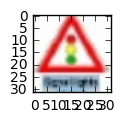

36 straight or right.png


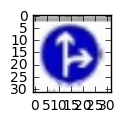

38 keep right.png


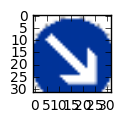

(7, 32, 32, 3)
(7, 32, 32, 1)


In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
myfiles=os.listdir('new-images/')
mylabels=[11,12,13,17,26,36,38]

imlist=[]
for file in myfiles:
    print(file)
    tmp=cv2.imread('new-images/'+file)
    tmp=cv2.cvtColor(tmp,cv2.COLOR_BGR2RGB)
    imlist.append(tmp) 
    plotmyimage(imlist[-1])
    
imarray=np.array(imlist,dtype='uint8')
print(imarray.shape)
imarray,_=ScaleDownImagesGray(imarray)
#imarray,_=ScaleDownImagesRGB(imarray)
print(imarray.shape)

### Predict the Sign Type for Each Image

In [9]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(imarray, mylabels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.857


### Analyze Performance

In [10]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
mysoftmax=tf.nn.softmax(logits)
top3=tf.nn.top_k(mysoftmax,k=3)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    mysoftmax_val=sess.run(mysoftmax,feed_dict={x:imarray,Keep:1.0})
    top3_val=sess.run(top3,feed_dict={x:imarray,Keep:1.0})

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [11]:
print(top3_val)

TopKV2(values=array([[  1.00000000e+00,   5.15003113e-17,   4.92466010e-19],
       [  1.00000000e+00,   7.40929471e-11,   3.24527002e-11],
       [  1.00000000e+00,   6.73457887e-11,   9.73689120e-13],
       [  9.99998689e-01,   5.55793179e-07,   4.40143509e-07],
       [  9.96717989e-01,   1.49497553e-03,   9.12756717e-04],
       [  9.99080539e-01,   7.70459534e-04,   1.04542392e-04],
       [  8.67152989e-01,   1.07700087e-01,   1.78232826e-02]], dtype=float32), indices=array([[11, 27, 30],
       [12, 14, 11],
       [13, 35,  9],
       [17, 34, 22],
       [18, 38, 26],
       [36, 38, 34],
       [38, 17, 12]]))


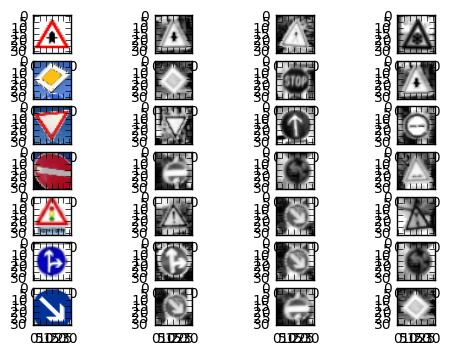

In [12]:
f,plts=plt.subplots(7,4)
for i in range(len(myfiles)):
    plts[i,0].imshow(imlist[i])
    #plts[i,0].set_title(myfiles[i])

    
    for j in range(0,3):
        s=np.where(y_train==top3_val[1][i][j])
        plts[i,j+1].imshow(X_train[s[0][0]].squeeze(),cmap='gray')
        #plts[i,j+2].set_title(mynames[top3_val[1][i][j]])
        #plts[i,j+2].set_title(top3_val[0][i][j])
